In [ ]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches

: 

In [ ]:
%matplotlib notebook

In [ ]:
# Simulation space dimensions, etc. edited by Clarke 02.21.2022
print('Starting simulation ...')
nx = 253 #orig 161
ny = 255
xmax,ymax = 1000.0, 1000.0 #micrometers

x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]; print('dy',dy)
nxmid = int(nx/2); print('nxmid =', nxmid); print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Define the box inside
Ldesiredx = 25. # Doesn't always work out to this because the grid is discretized
boxradx = int(Ldesiredx/dx)
Lx = boxradx*dx; print('Lx =', Lx)

Ldesiredy = 50.
boxrady = int(Ldesiredy/dy)
Ly = boxrady*dy; print('Ly =', Ly)

ixboxmin = nxmid-boxradx
ixboxmax = nxmid+boxradx
iyboxmin = nymid-boxrady
iyboxmax = nymid+boxrady

# Setting up to slice through the volume
ixbox = slice(ixboxmin,ixboxmax); print(ixbox)
iybox = slice(iyboxmin,iyboxmax); print(iybox)

: 

In [4]:
# Compute diffusion coefficient at this temperature
D_SI_300 = 24.0e-6 # m^2/s
D_300 = D_SI_300 * 1e6  # um^2/us
Temp = 260.0
Pressure = .2
acoef = 2.072
D = D_300*(Temp/300)**acoef/(Pressure/1.0); print(D_300, D)

# Here's the part that involved some guesswork ... getting the Neumann coefficient
gneumann_nu_kin = D/(nx-1); print('gneumann_kin', gneumann_nu_kin)
nu_kin_ml = 0.1633333333
kfactor = gneumann_nu_kin/nu_kin_ml; print('kfactor', kfactor)
alphasigma = .36; print('alpha*sigma', alphasigma)
gneumann = kfactor * nu_kin_ml; print('gneumann', gneumann)

# This is the far-field boundary
udirichlet = alphasigma

24.0 89.20943386022752
gneumann_kin 0.3568377354409101
kfactor 2.184720829675923
alpha*sigma 0.36
gneumann 0.3568377354409101


In [5]:
# Aesthetics ... fills in the box with an arbitrary constant value
def fillin(un,ixbox,iybox,overrideflag=0,overrideval=0):
    border = cp(un[ixbox.start-1,iybox.start])
    if(overrideflag == 1):
        border = overrideval
    un[ixbox,iybox] = border
    return un

In [6]:
# Initialize u0 and un as ones/zeros matrices 
u0 = np.ones([nx, ny])*udirichlet # old u values
u0 = fillin(u0,ixbox, iybox)

In [7]:
# Physical parameters translated into values for computation
dx2 = dx**2
dy2 = dy**2
dt = (dx2+dy2)/D/10; print(dt)
Dxeff = D*dt/dx2
Dyeff = D*dt/dy2
gneumanneffx = gneumann*dt/dx**2; print('gneumann effective, x', gneumanneffx)
gneumanneffy = gneumann*dt/dy**2; print('gneumann effective, y', gneumanneffy)

# The differential equation solver
def propagate(u0_orig,ixbox,iybox,gneumanneffx,gneumanneffy,Dxeff,Dyeff):
    
    # Diffusion
    u0 = cp(u0_orig)
    un = np.zeros(np.shape(u0))
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
        
    # Pull out the stop and start indices
    ixmin = ixbox.start
    ixmax = ixbox.stop-1
    iymin = iybox.start
    iymax = iybox.stop-1

    # Neumann inner boundary
    un[ixmin-1,iybox] = u0[ixmin-1,iybox] +(u0[ixmin-2,iybox] - u0[ixmin-1,iybox])*Dxeff -gneumanneffx
    un[ixmax+1,iybox] = u0[ixmax+1,iybox] +(u0[ixmax+2,iybox] - u0[ixmax+1,iybox])*Dxeff -gneumanneffx

    un[ixbox,iymin-1] = u0[ixbox,iymin-1] +(u0[ixbox,iymin-2] - u0[ixbox,iymin-1])*Dyeff -gneumanneffy
    un[ixbox,iymax+1] = u0[ixbox,iymax+1] +(u0[ixbox,iymax+2] - u0[ixbox,iymax+1])*Dyeff -gneumanneffy
    
    # Also zero-out inside the box (this is just aesthetic)
    un = fillin(un,ixbox, iybox, overrideflag=1, overrideval=0)
    
    return un

0.035310201664787995
gneumann effective, x 0.00078750077500155
gneumann effective, y 0.0008129023999999999


In [ ]:
# Initialize the state of the vapor field
un = cp(u0)

In [22]:
# Propagate forward a bunch of times
ntimes = 40000
for i in range(ntimes):
    un = propagate(un,ixbox,iybox,gneumanneffx,gneumanneffy,Dxeff,Dyeff)

<IPython.core.display.Javascript object>


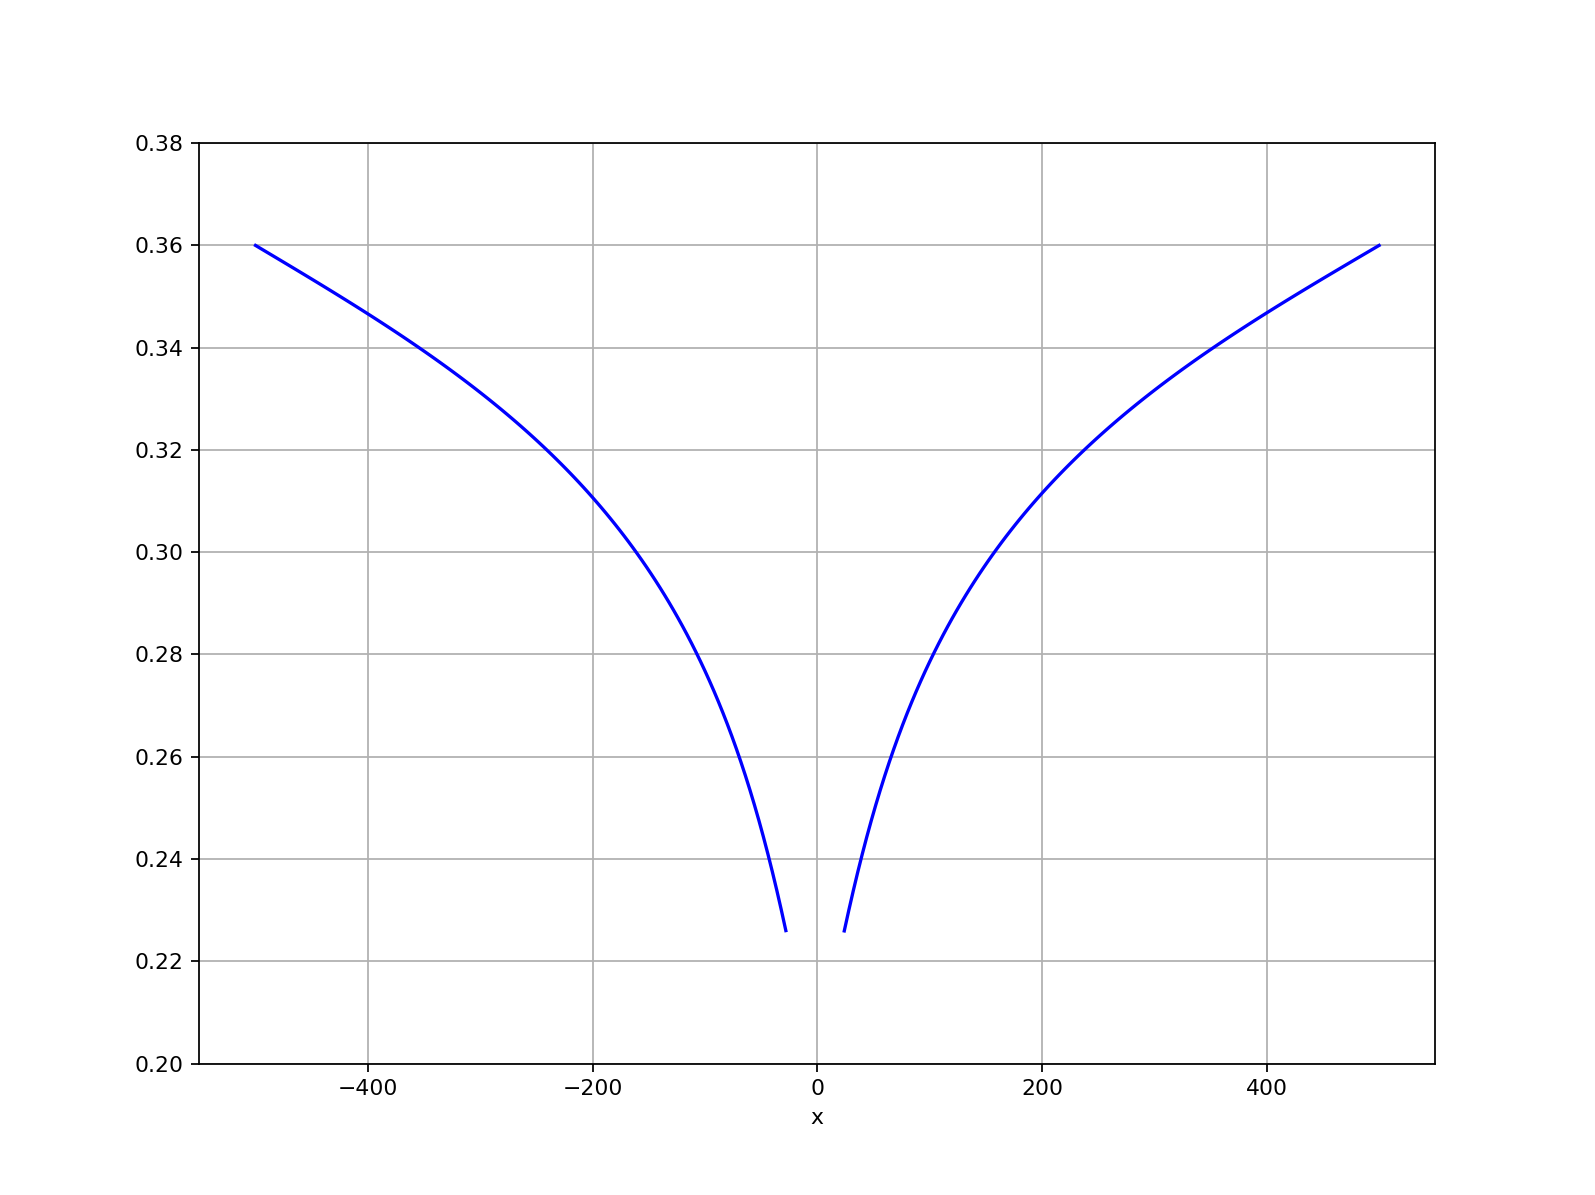

<IPython.core.display.Javascript object>


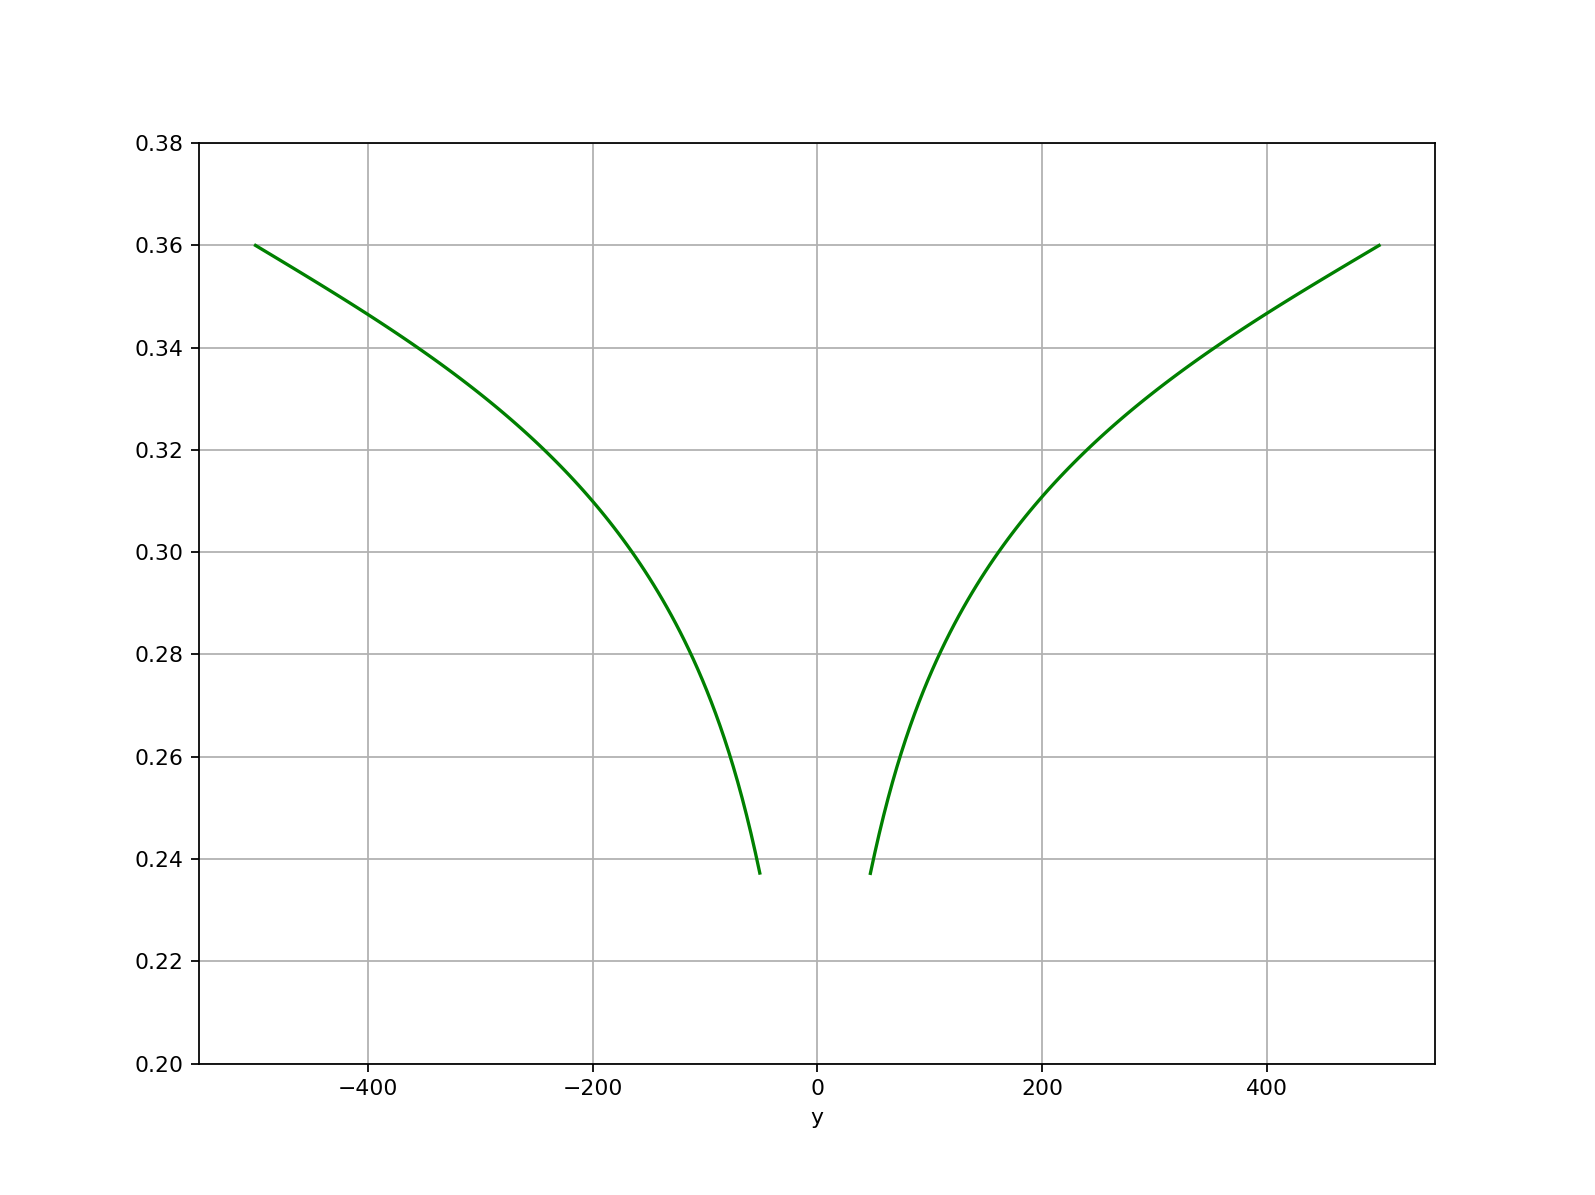

In [24]:
# Plotting from far afield up to the box
vertical_limits = [.2,.38]

ixbox_pre = slice(0,ixboxmin)
ixbox_post = slice(ixboxmax,nx)
plt.figure()
plt.plot(x[ixbox_pre], un[ixbox_pre,nymid], 'blue')
plt.plot(x[ixbox_post],un[ixbox_post,nymid],'blue')
plt.xlabel('x')
plt.ylim(vertical_limits)
plt.grid(True)

iybox_pre = slice(0,iyboxmin)
iybox_post = slice(iyboxmax,ny)
plt.figure()
plt.plot(y[iybox_pre], un[nxmid,iybox_pre], 'green')
plt.plot(y[iybox_post],un[nxmid,iybox_post],'green')
plt.xlabel('y')
plt.ylim(vertical_limits)
plt.grid(True)

c_r (x-direction) = 0.3780902675769443 %


<IPython.core.display.Javascript object>


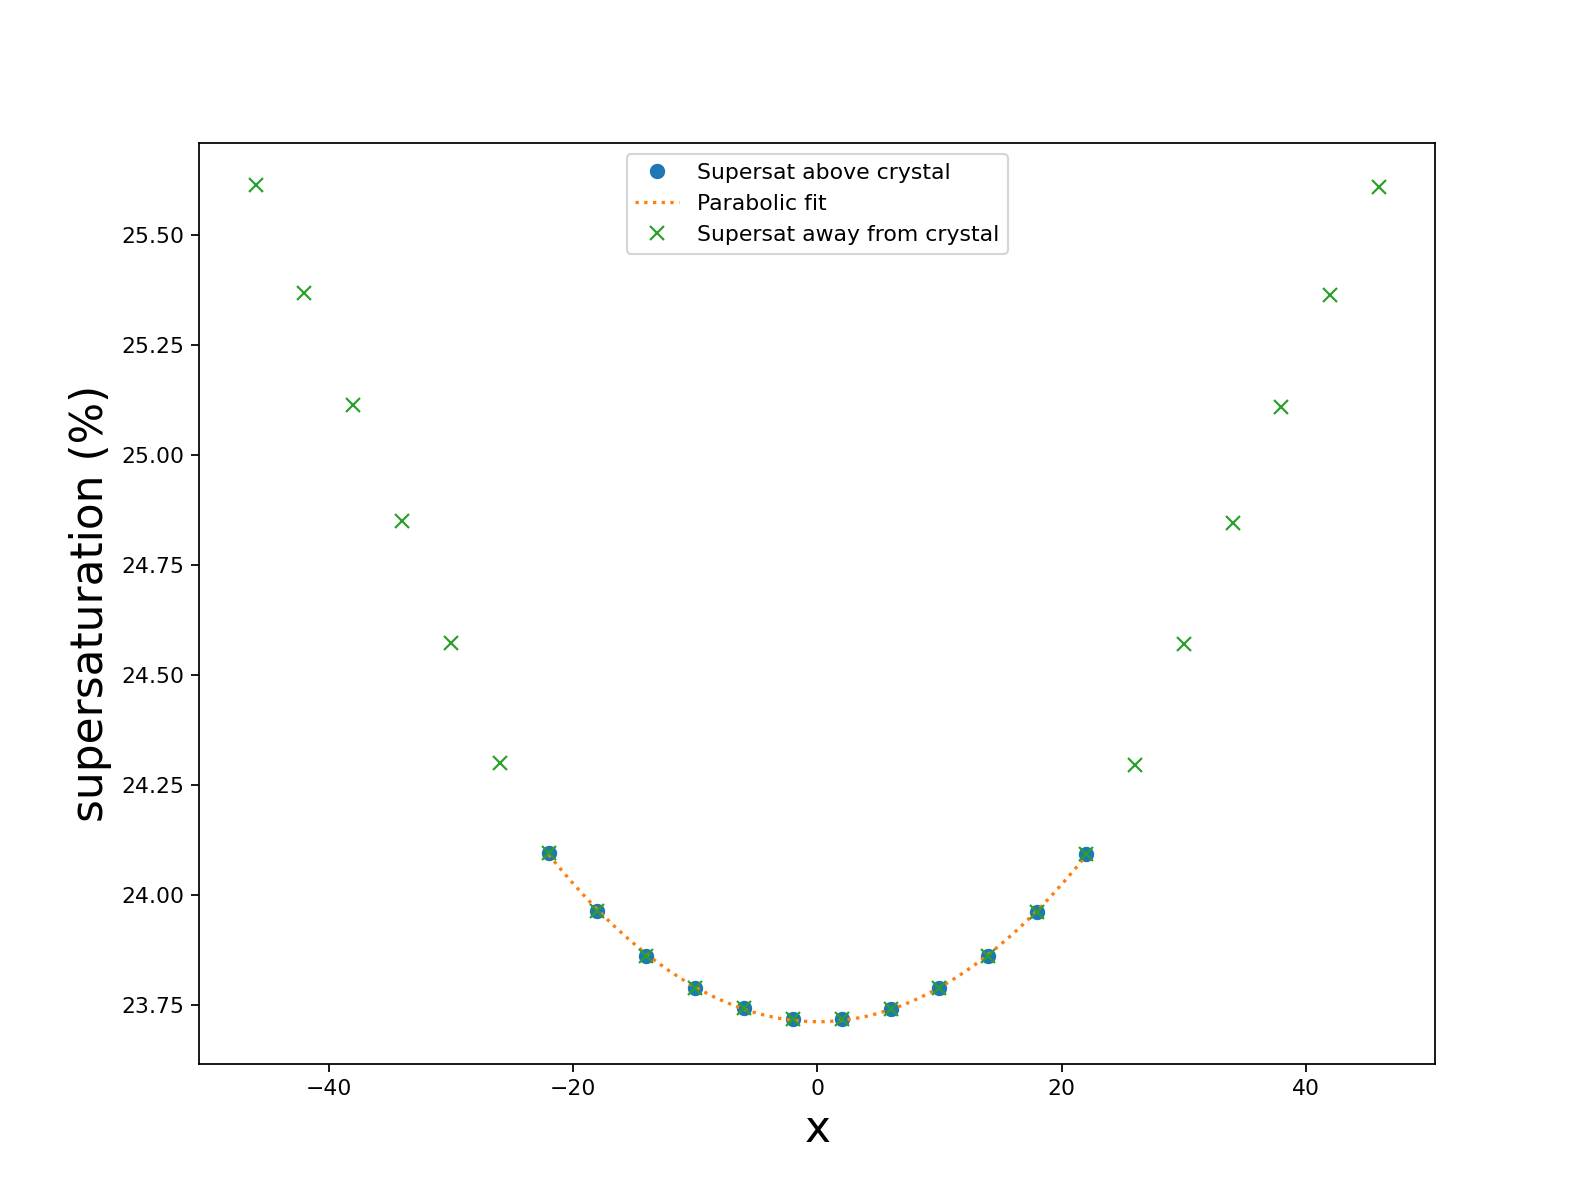

[ 7.82691545e-06 -5.81779156e-07  2.37126511e-01]
c_r (y-direction) = 1.2639075519452176 %


<IPython.core.display.Javascript object>


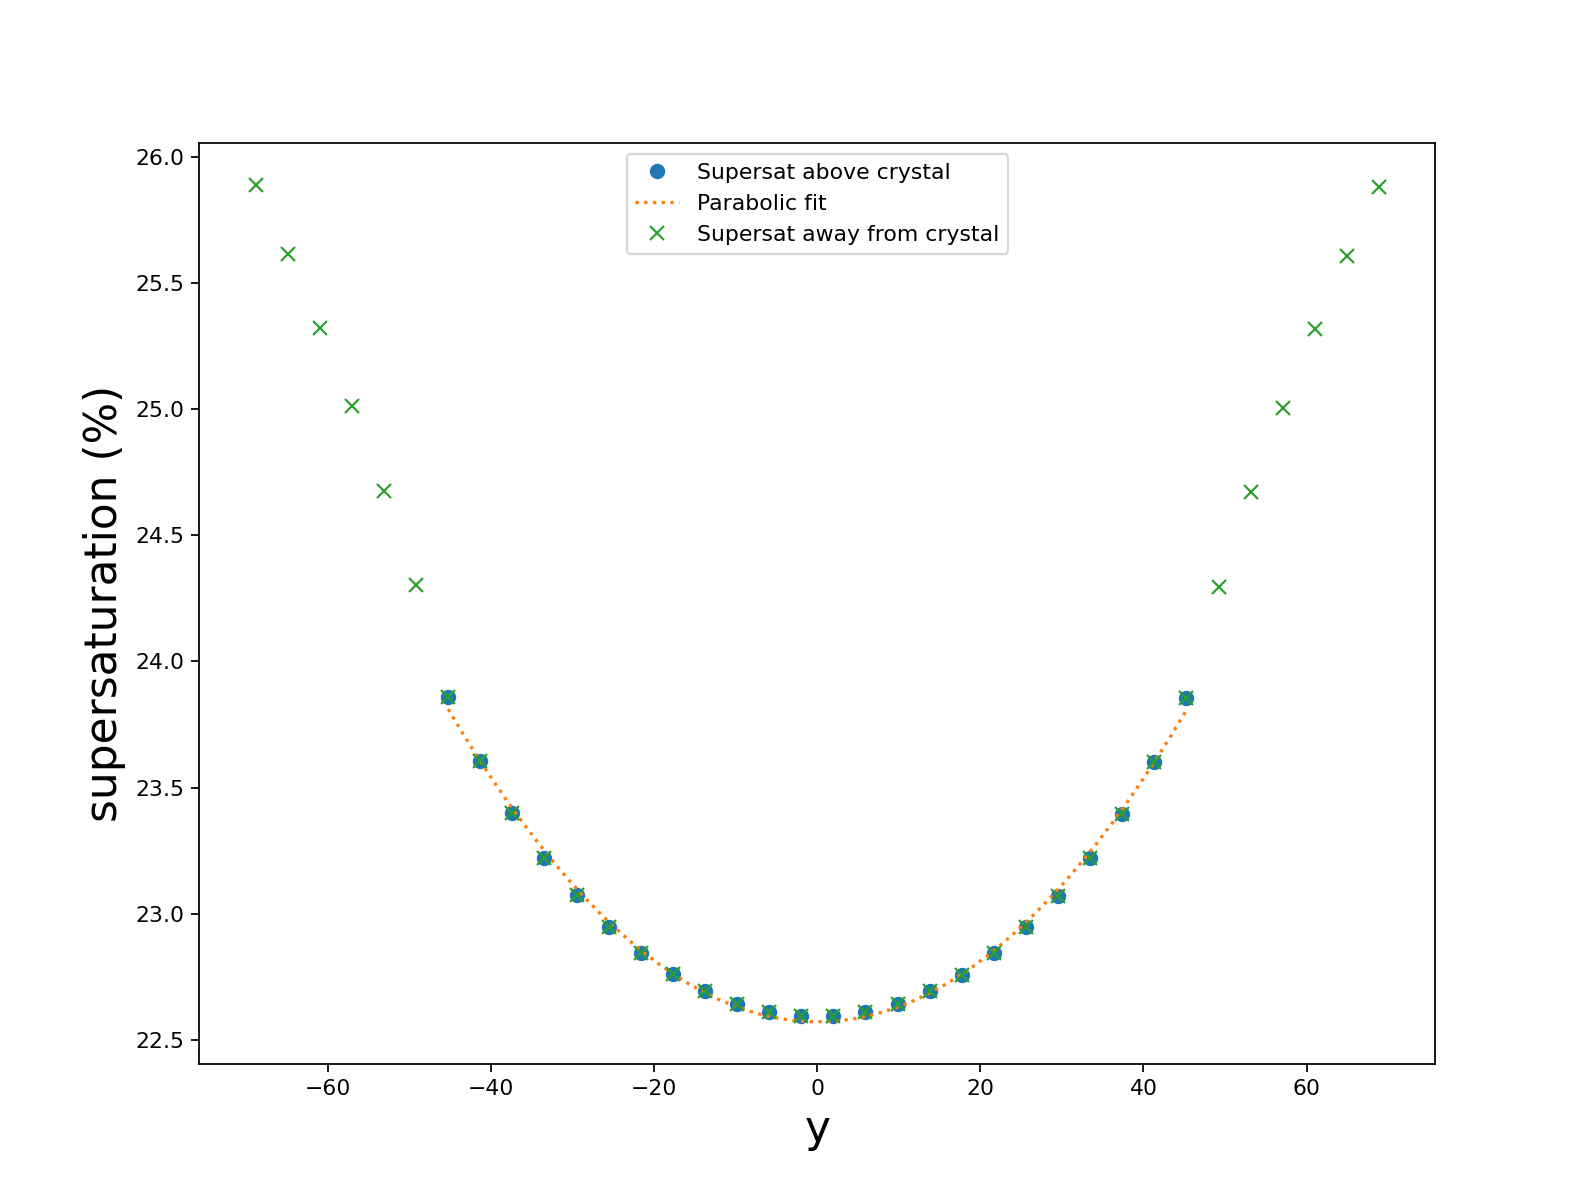

[ 6.04207851e-06 -4.33163742e-07  2.25707201e-01]


In [36]:
# Decide how much we want to extend the plotting to either side of the box
iextend = 6

# Now a slice just across one of the box surfaces ( in the x dimension)
uslice = un[ixbox,nymid+boxrady]
print('c_r (x-direction) =', (max(uslice)-min(uslice))*100, '%')

# This is right above the surface
plt.figure()
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uslice*100,'o')
p = np.polyfit(xshifted,uslice,2); print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory)*100,':')

# This is extended a bit to either side
bigixbox = [ix for ix in range(nxmid-boxradx-iextend,nxmid+boxradx+iextend)]
biguslice = un[bigixbox,nymid+boxrady]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguslice*100,'x',lw=2)
plt.xlabel('x',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)

# Add a legend
plt.legend(['Supersat above crystal','Parabolic fit','Supersat away from crystal'],loc='upper center')


# Now a slice just across one of the box surfaces ( in the Y dimension)
uslice = un[nxmid+boxradx, iybox]
print('c_r (y-direction) =', (max(uslice)-min(uslice))*100, '%')

plt.figure()
yshifted = y[iybox]-y[nymid]+dy/2
plt.plot(yshifted,uslice*100,'o')
p = np.polyfit(yshifted,uslice,2); print(p)
yshifted_theory = np.linspace(min(yshifted),max(yshifted))
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory)*100,':')

bigiybox = [iy for iy in range(nymid-boxrady-iextend,nymid+boxrady+iextend)]
biguslice = un[nxmid+boxradx,bigiybox]
bigyshifted = y[bigiybox]-y[nymid]+dy/2
plt.plot(bigyshifted,biguslice*100,'x',lw=2)
plt.xlabel('y',fontsize=20)
plt.ylabel('supersaturation (%)',fontsize=20)

# Add a legend
plt.legend(['Supersat above crystal','Parabolic fit','Supersat away from crystal'],loc='upper center')

<IPython.core.display.Javascript object>


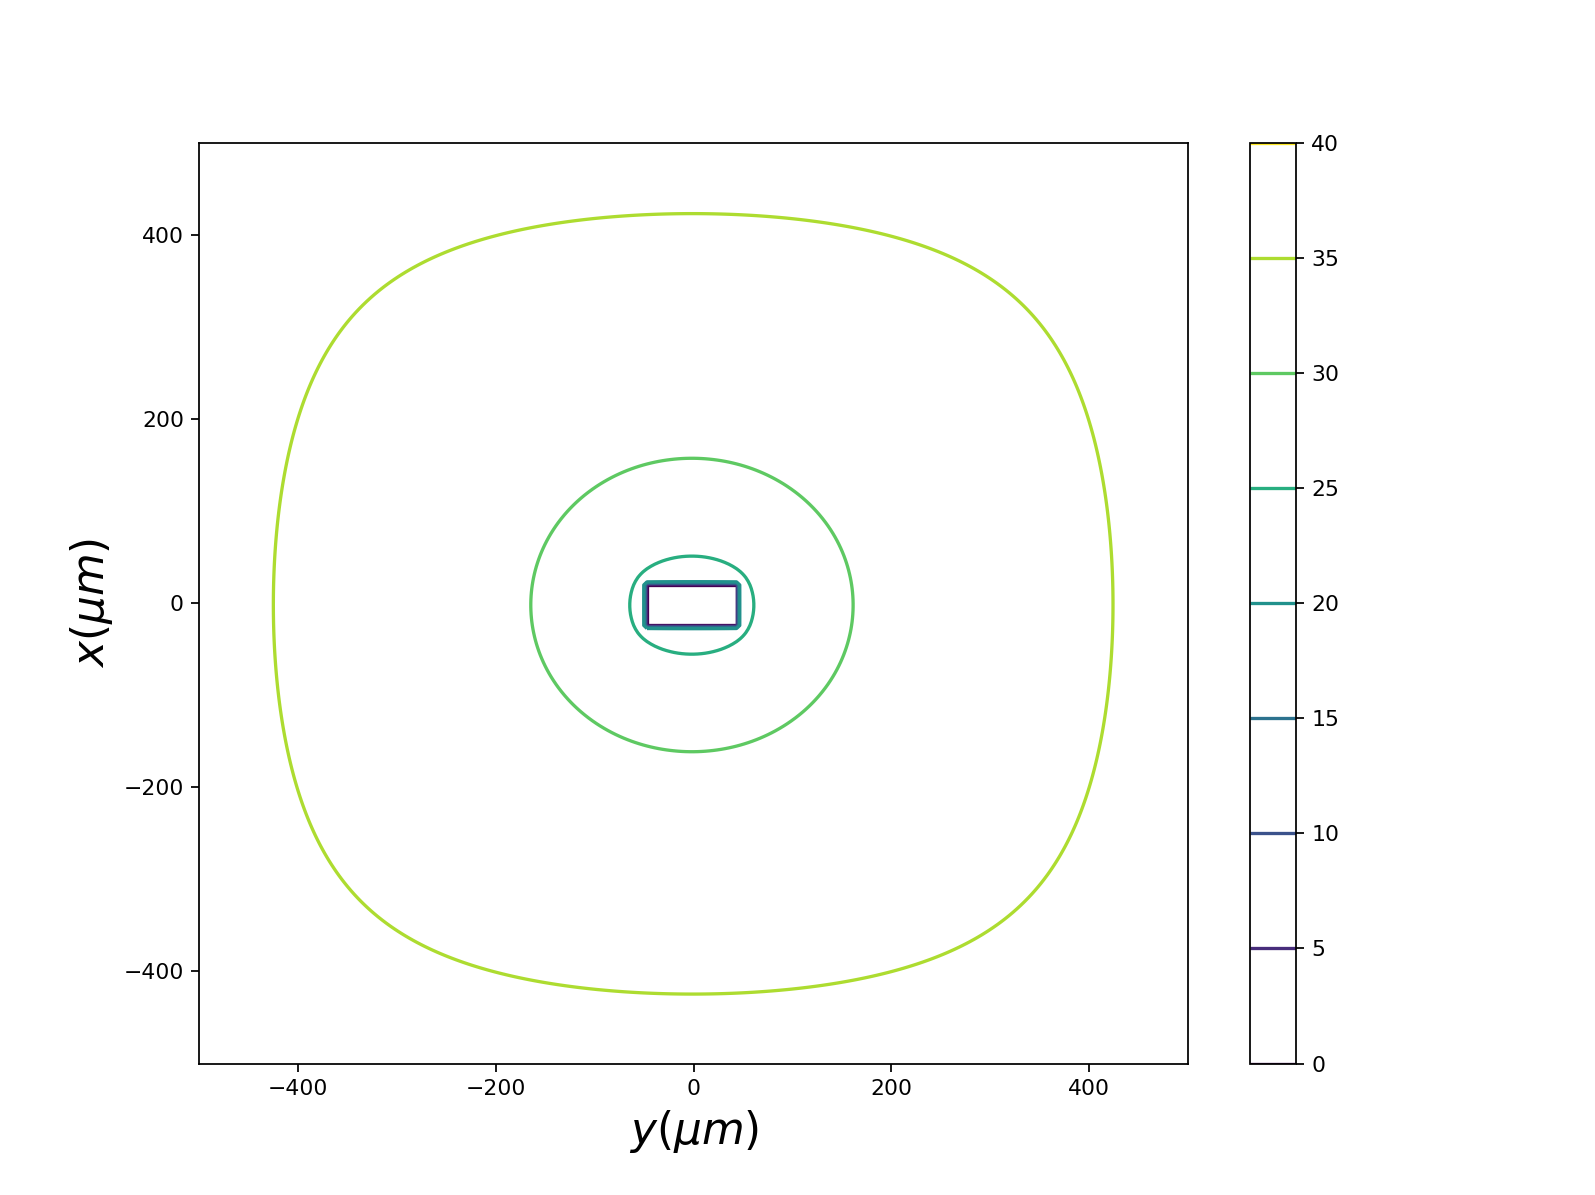

In [23]:
# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(y,x,un*100)
ax.set_xlabel(r'$y (\mu m)$', fontsize=20)
ax.set_ylabel(r'$x (\mu m)$', fontsize=20)
fig.colorbar(CS)